<a href="https://www.kaggle.com/code/gonzalogrecco144/working-with-bigquery?scriptVersionId=103164146" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bq_helper
from bq_helper import BigQueryHelper
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

## Looking the data

In [2]:
chicago_crime = BigQueryHelper('bigquery-public-data', 'chicago_crime')
chicago_crime.head('crime')

Using Kaggle's public dataset BigQuery integration.


,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,9663588,HX313636,2014-06-21 03:00:00+00:00,020XX S WENTWORTH AVE,0479,BATTERY,AGG: HANDS/FIST/FEET SERIOUS INJURY,STREET,False,False,...,25,34,04B,1175356.0,1890576.0,2014,2018-02-10 03:50:01+00:00,41.855119,-87.631845,"(41.855118781, -87.631844657)"
1,12142920,JD340768,2020-08-21 10:30:00+00:00,075XX W MYRTLE AVE,1360,CRIMINAL TRESPASS,TO VEHICLE,VEHICLE NON-COMMERCIAL,False,False,...,41,10,26,1125181.0,1940648.0,2020,2020-08-28 03:51:47+00:00,41.993500,-87.814901,"(41.993500162, -87.814901223)"
2,9741459,HX392010,2014-08-18 03:24:00+00:00,130XX S EVANS AVE,1365,CRIMINAL TRESPASS,TO RESIDENCE,CHA APARTMENT,True,False,...,9,54,26,1183714.0,1818723.0,2014,2018-02-10 03:50:01+00:00,41.657755,-87.603405,"(41.6577554, -87.60340512)"
3,9746221,HX396061,2014-08-20 08:00:00+00:00,043XX W 53RD ST,0915,MOTOR VEHICLE THEFT,"TRUCK, BUS, MOTOR HOME",PARKING LOT/GARAGE(NON.RESID.),False,False,...,23,57,07,1148402.0,1869119.0,2014,2018-02-10 03:50:01+00:00,41.796799,-87.731330,"(41.796799433, -87.731330275)"
4,10229168,HY416530,2015-09-09 09:00:00+00:00,057XX W 64TH PL,1780,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,RESIDENCE,False,False,...,13,64,26,1139193.0,1861206.0,2015,2018-02-10 03:50:01+00:00,41.775257,-87.765293,"(41.775256781, -87.765292977)"


In [3]:
chicago_crime.table_schema('crime')

,name,type,mode,description
0,unique_key,INTEGER,REQUIRED,None
1,case_number,STRING,NULLABLE,None
2,date,TIMESTAMP,NULLABLE,None
3,block,STRING,NULLABLE,None
4,iucr,STRING,NULLABLE,None
5,primary_type,STRING,NULLABLE,None
6,description,STRING,NULLABLE,None
7,location_description,STRING,NULLABLE,None
8,arrest,BOOLEAN,NULLABLE,None
9,domestic,BOOLEAN,NULLABLE,None


#### • *We aren't extracting data from the year 2022 because it isn't over yet.*
#### • *For the years 2020-2021 neither because the lockdown due to the pandemic will change some average values and won't reflect the full picture.*
#### • *We'll compare the range 2020-2021 with previous years to see the lockdown impact in crimes.*

## Total crimes and arrest per year

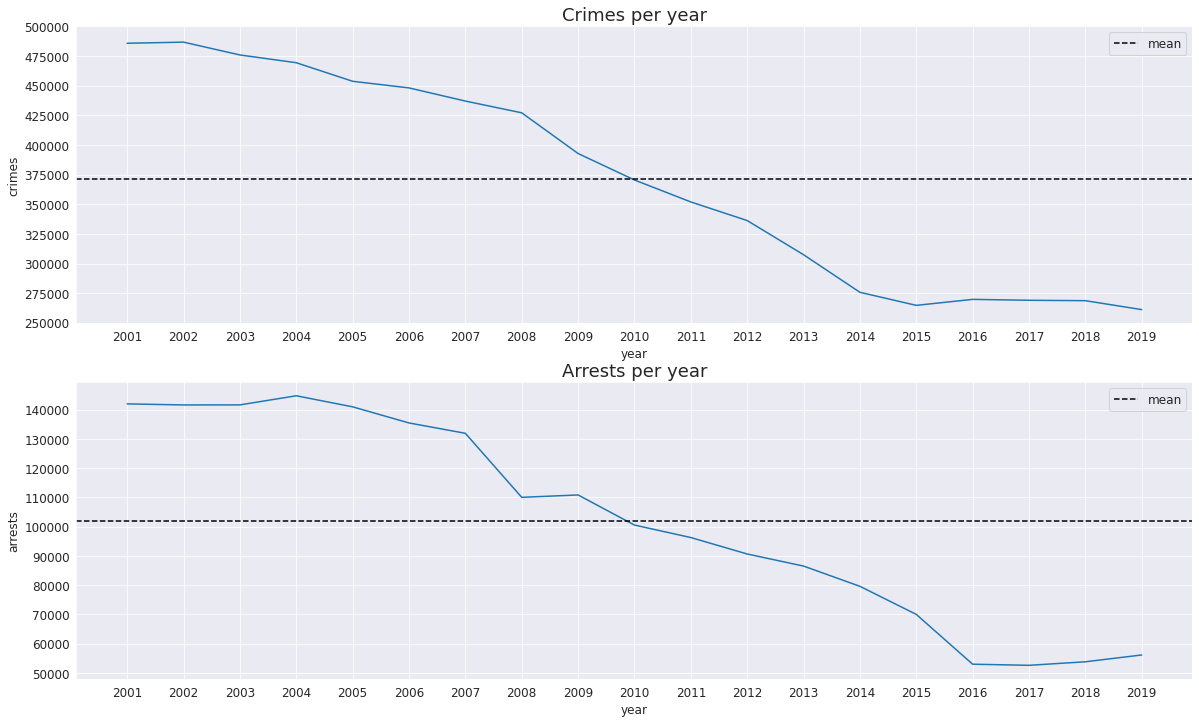

In [4]:
crimes_per_year = """
                  SELECT year, COUNT(*) AS crimes , (SELECT ROUND(COUNT(unique_key) / COUNT(DISTINCT(year)), 0)
                                                    FROM `bigquery-public-data.chicago_crime.crime`
                                                    WHERE year < 2020) AS average
                  FROM `bigquery-public-data.chicago_crime.crime`
                  WHERE year < 2020
                  GROUP BY year
                  ORDER BY year 
                  """

arrest_per_year = """
                  SELECT year, COUNT(*) AS arrests , (SELECT ROUND(COUNT(unique_key) / COUNT(DISTINCT(year)), 0)
                                                    FROM `bigquery-public-data.chicago_crime.crime`
                                                    WHERE year < 2020 AND arrest = TRUE) AS average
                  FROM `bigquery-public-data.chicago_crime.crime`
                  WHERE year < 2020 AND arrest = TRUE
                  GROUP BY year
                  ORDER BY year 
                  """

crimes_per_year_data = chicago_crime.query_to_pandas(crimes_per_year)
arrest_per_year_data = chicago_crime.query_to_pandas(arrest_per_year)

fig, axes = plt.subplots(2, 1, figsize=(20, 12))

plt.sca(axes[0])
sns.lineplot(x='year', y='crimes', data=crimes_per_year_data).set_title('Crimes per year', fontsize=18)
plt.xticks(np.arange(2001, 2020, 1))
plt.yticks(np.arange(250000, 525000, 25000))
plt.axhline(crimes_per_year_data['average'][0], linestyle='--', color='k', label='mean')
plt.legend()

plt.sca(axes[1])
sns.lineplot(x='year', y='arrests', data=arrest_per_year_data).set_title('Arrests per year', fontsize=18)
plt.xticks(np.arange(2001, 2020, 1))
plt.yticks(np.arange(50000, 150000, 10000))
plt.axhline(arrest_per_year_data['average'][0], linestyle='--', color='k', label='mean')
plt.legend()
plt.show()

#### • *It seems that there is a negative correlation between years and crimes (especially in the 2008-2014 range).*
#### • *The years-arrests plot look very similar.*
#### • *It would be interesting to know why crimes decrease over the years and if this has happened in other major cities of the united states.*

## Total crimes and arrests per year (top five primary types)

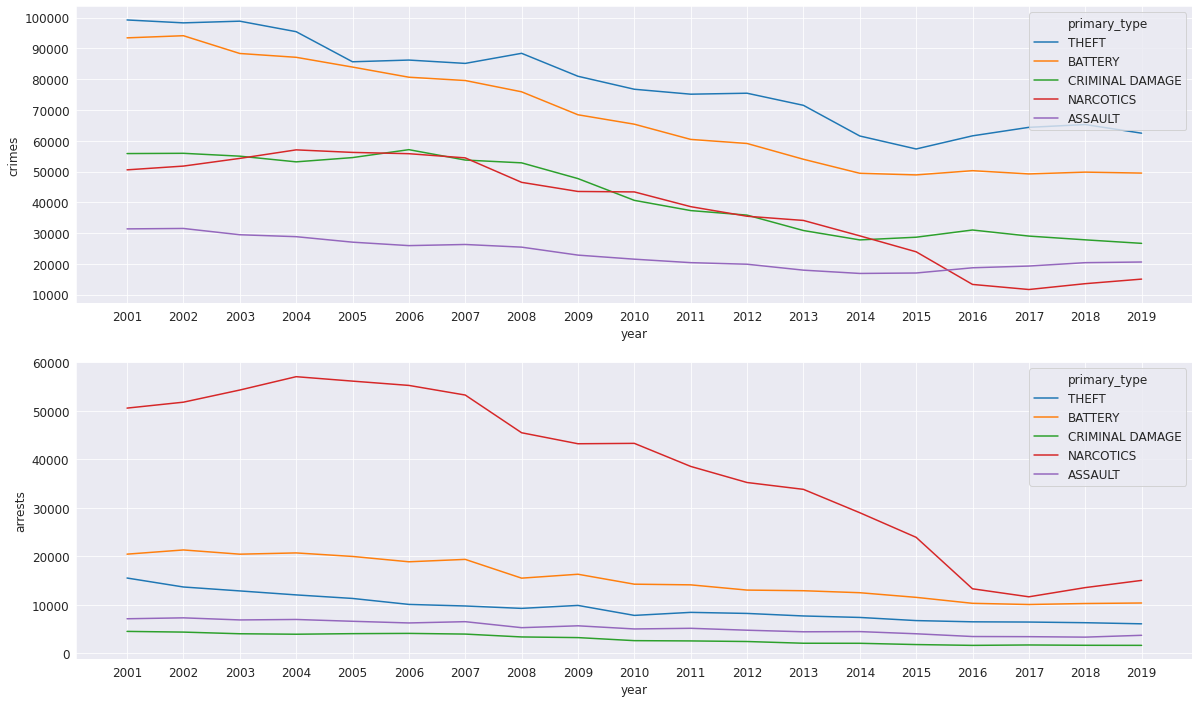

In [5]:
crimes_types = """
               SELECT year, primary_type, COUNT(*) AS crimes
               FROM `bigquery-public-data.chicago_crime.crime`
               WHERE year < 2020 
               AND primary_type IN ('THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT')
               GROUP BY year, primary_type
               ORDER BY crimes DESC
               """

arrest_types = """
               SELECT year, primary_type, COUNT(*) AS arrests
               FROM `bigquery-public-data.chicago_crime.crime`
               WHERE year < 2020 AND arrest = TRUE
               AND primary_type IN ('THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT')
               GROUP BY year, primary_type
               ORDER BY arrests DESC
               """

crimes_types_data = chicago_crime.query_to_pandas(crimes_types)
arrest_types_data = chicago_crime.query_to_pandas(arrest_types)

fig, axes = plt.subplots(2, 1, figsize=(20, 12))

plt.sca(axes[0])
sns.lineplot(x='year', y='crimes', hue='primary_type', data=crimes_types_data)
plt.xticks(np.arange(2001, 2020, 1))
plt.yticks(np.arange(10000, 110000, 10000))

plt.sca(axes[1])
sns.lineplot(x='year', y='arrests', hue='primary_type', data=arrest_types_data, hue_order=['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT'])
plt.xticks(np.arange(2001, 2020, 1))
plt.yticks(np.arange(0, 70000, 10000))

plt.show()


#### • *We see that the types 'theft' and 'battery' are the most common (not surprising).*
#### • *The type 'narcotics' has a high percentage of arrests (we will see it in detail later).*
#### • *We will analyze the change through the years in more detail.*

## Change through the years

In [6]:
crimes_change = """
                SELECT primary_type, "Crime" AS Category,
                CONCAT(ROUND((COUNTIF(year=2002) - COUNTIF(year=2001)) / CASE WHEN COUNTIF(year=2001)=0 THEN NULL ELSE COUNTIF(year=2001) END * 100, 1),'%') AS Y2002,
                CONCAT(ROUND((COUNTIF(year=2003) - COUNTIF(year=2002)) / CASE WHEN COUNTIF(year=2002)=0 THEN NULL ELSE COUNTIF(year=2002) END * 100, 1),'%') AS Y2003,
                CONCAT(ROUND((COUNTIF(year=2004) - COUNTIF(year=2003)) / CASE WHEN COUNTIF(year=2003)=0 THEN NULL ELSE COUNTIF(year=2003) END * 100, 1),'%') AS Y2004,
                CONCAT(ROUND((COUNTIF(year=2005) - COUNTIF(year=2004)) / CASE WHEN COUNTIF(year=2004)=0 THEN NULL ELSE COUNTIF(year=2004) END * 100, 1),'%') AS Y2005,
                CONCAT(ROUND((COUNTIF(year=2006) - COUNTIF(year=2005)) / CASE WHEN COUNTIF(year=2005)=0 THEN NULL ELSE COUNTIF(year=2005) END * 100, 1),'%') AS Y2006,
                CONCAT(ROUND((COUNTIF(year=2007) - COUNTIF(year=2006)) / CASE WHEN COUNTIF(year=2006)=0 THEN NULL ELSE COUNTIF(year=2006) END * 100, 1),'%') AS Y2007,
                CONCAT(ROUND((COUNTIF(year=2008) - COUNTIF(year=2007)) / CASE WHEN COUNTIF(year=2007)=0 THEN NULL ELSE COUNTIF(year=2007) END * 100, 1),'%') AS Y2008,
                CONCAT(ROUND((COUNTIF(year=2009) - COUNTIF(year=2008)) / CASE WHEN COUNTIF(year=2008)=0 THEN NULL ELSE COUNTIF(year=2008) END * 100, 1),'%') AS Y2009,
                CONCAT(ROUND((COUNTIF(year=2010) - COUNTIF(year=2009)) / CASE WHEN COUNTIF(year=2009)=0 THEN NULL ELSE COUNTIF(year=2009) END * 100, 1),'%') AS Y2010,
                CONCAT(ROUND((COUNTIF(year=2011) - COUNTIF(year=2010)) / CASE WHEN COUNTIF(year=2010)=0 THEN NULL ELSE COUNTIF(year=2010) END * 100, 1),'%') AS Y2011,
                CONCAT(ROUND((COUNTIF(year=2012) - COUNTIF(year=2011)) / CASE WHEN COUNTIF(year=2011)=0 THEN NULL ELSE COUNTIF(year=2011) END * 100, 1),'%') AS Y2012,
                CONCAT(ROUND((COUNTIF(year=2013) - COUNTIF(year=2012)) / CASE WHEN COUNTIF(year=2012)=0 THEN NULL ELSE COUNTIF(year=2012) END * 100, 1),'%') AS Y2013,
                CONCAT(ROUND((COUNTIF(year=2014) - COUNTIF(year=2013)) / CASE WHEN COUNTIF(year=2013)=0 THEN NULL ELSE COUNTIF(year=2013) END * 100, 1),'%') AS Y2014,
                CONCAT(ROUND((COUNTIF(year=2015) - COUNTIF(year=2014)) / CASE WHEN COUNTIF(year=2014)=0 THEN NULL ELSE COUNTIF(year=2014) END * 100, 1),'%') AS Y2015,
                CONCAT(ROUND((COUNTIF(year=2016) - COUNTIF(year=2015)) / CASE WHEN COUNTIF(year=2015)=0 THEN NULL ELSE COUNTIF(year=2015) END * 100, 1),'%') AS Y2016,
                CONCAT(ROUND((COUNTIF(year=2017) - COUNTIF(year=2016)) / CASE WHEN COUNTIF(year=2016)=0 THEN NULL ELSE COUNTIF(year=2016) END * 100, 1),'%') AS Y2017,
                CONCAT(ROUND((COUNTIF(year=2018) - COUNTIF(year=2017)) / CASE WHEN COUNTIF(year=2017)=0 THEN NULL ELSE COUNTIF(year=2017) END * 100, 1),'%') AS Y2018,
                CONCAT(ROUND((COUNTIF(year=2019) - COUNTIF(year=2018)) / CASE WHEN COUNTIF(year=2018)=0 THEN NULL ELSE COUNTIF(year=2018) END * 100, 1),'%') AS Y2019
                FROM `bigquery-public-data.chicago_crime.crime`
                WHERE primary_type IN ('THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT')
                GROUP BY primary_type
                UNION ALL
                SELECT primary_type, "Arrest" AS Category,
                CONCAT(ROUND((COUNTIF(year=2002) - COUNTIF(year=2001)) / CASE WHEN COUNTIF(year=2001)=0 THEN NULL ELSE COUNTIF(year=2001) END * 100, 1),'%') AS Y2002,
                CONCAT(ROUND((COUNTIF(year=2003) - COUNTIF(year=2002)) / CASE WHEN COUNTIF(year=2002)=0 THEN NULL ELSE COUNTIF(year=2002) END * 100, 1),'%') AS Y2003,
                CONCAT(ROUND((COUNTIF(year=2004) - COUNTIF(year=2003)) / CASE WHEN COUNTIF(year=2003)=0 THEN NULL ELSE COUNTIF(year=2003) END * 100, 1),'%') AS Y2004,
                CONCAT(ROUND((COUNTIF(year=2005) - COUNTIF(year=2004)) / CASE WHEN COUNTIF(year=2004)=0 THEN NULL ELSE COUNTIF(year=2004) END * 100, 1),'%') AS Y2005,
                CONCAT(ROUND((COUNTIF(year=2006) - COUNTIF(year=2005)) / CASE WHEN COUNTIF(year=2005)=0 THEN NULL ELSE COUNTIF(year=2005) END * 100, 1),'%') AS Y2006,
                CONCAT(ROUND((COUNTIF(year=2007) - COUNTIF(year=2006)) / CASE WHEN COUNTIF(year=2006)=0 THEN NULL ELSE COUNTIF(year=2006) END * 100, 1),'%') AS Y2007,
                CONCAT(ROUND((COUNTIF(year=2008) - COUNTIF(year=2007)) / CASE WHEN COUNTIF(year=2007)=0 THEN NULL ELSE COUNTIF(year=2007) END * 100, 1),'%') AS Y2008,
                CONCAT(ROUND((COUNTIF(year=2009) - COUNTIF(year=2008)) / CASE WHEN COUNTIF(year=2008)=0 THEN NULL ELSE COUNTIF(year=2008) END * 100, 1),'%') AS Y2009,
                CONCAT(ROUND((COUNTIF(year=2010) - COUNTIF(year=2009)) / CASE WHEN COUNTIF(year=2009)=0 THEN NULL ELSE COUNTIF(year=2009) END * 100, 1),'%') AS Y2010,
                CONCAT(ROUND((COUNTIF(year=2011) - COUNTIF(year=2010)) / CASE WHEN COUNTIF(year=2010)=0 THEN NULL ELSE COUNTIF(year=2010) END * 100, 1),'%') AS Y2011,
                CONCAT(ROUND((COUNTIF(year=2012) - COUNTIF(year=2011)) / CASE WHEN COUNTIF(year=2011)=0 THEN NULL ELSE COUNTIF(year=2011) END * 100, 1),'%') AS Y2012,
                CONCAT(ROUND((COUNTIF(year=2013) - COUNTIF(year=2012)) / CASE WHEN COUNTIF(year=2012)=0 THEN NULL ELSE COUNTIF(year=2012) END * 100, 1),'%') AS Y2013,
                CONCAT(ROUND((COUNTIF(year=2014) - COUNTIF(year=2013)) / CASE WHEN COUNTIF(year=2013)=0 THEN NULL ELSE COUNTIF(year=2013) END * 100, 1),'%') AS Y2014,
                CONCAT(ROUND((COUNTIF(year=2015) - COUNTIF(year=2014)) / CASE WHEN COUNTIF(year=2014)=0 THEN NULL ELSE COUNTIF(year=2014) END * 100, 1),'%') AS Y2015,
                CONCAT(ROUND((COUNTIF(year=2016) - COUNTIF(year=2015)) / CASE WHEN COUNTIF(year=2015)=0 THEN NULL ELSE COUNTIF(year=2015) END * 100, 1),'%') AS Y2016,
                CONCAT(ROUND((COUNTIF(year=2017) - COUNTIF(year=2016)) / CASE WHEN COUNTIF(year=2016)=0 THEN NULL ELSE COUNTIF(year=2016) END * 100, 1),'%') AS Y2017,
                CONCAT(ROUND((COUNTIF(year=2018) - COUNTIF(year=2017)) / CASE WHEN COUNTIF(year=2017)=0 THEN NULL ELSE COUNTIF(year=2017) END * 100, 1),'%') AS Y2018,
                CONCAT(ROUND((COUNTIF(year=2019) - COUNTIF(year=2018)) / CASE WHEN COUNTIF(year=2018)=0 THEN NULL ELSE COUNTIF(year=2018) END * 100, 1),'%') AS Y2019
                FROM `bigquery-public-data.chicago_crime.crime`
                WHERE primary_type IN ('THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT') AND arrest = TRUE
                GROUP BY primary_type
                """

crimes_change_data = chicago_crime.query_to_pandas(crimes_change)
crimes_change_data.sort_values(['primary_type', 'Category'], ascending = [True, False]).set_index(['primary_type', 'Category'])

Y2002  Y2003  Y2004   Y2005   Y2006  Y2007   Y2008  \
primary_type    Category                                                        
ASSAULT         Crime       0.4%  -6.5%  -2.1%   -6.2%   -4.1%   1.4%   -3.3%   
                Arrest      2.7%  -5.9%   1.4%   -5.3%   -5.2%   4.2%  -18.9%   
BATTERY         Crime       0.7%  -6.1%  -1.4%   -3.6%   -3.9%  -1.3%   -4.6%   
                Arrest      4.2%  -4.1%   1.3%   -3.5%   -5.5%   2.6%  -19.9%   
CRIMINAL DAMAGE Crime       0.2%  -1.7%  -3.4%    2.6%    4.7%  -5.9%   -1.7%   
                Arrest     -3.2%  -7.8%  -2.3%      3%    1.3%  -3.4%  -14.8%   
NARCOTICS       Crime       2.4%   4.8%   5.1%   -1.4%   -0.7%  -2.4%  -14.6%   
                Arrest      2.4%   4.8%   5.1%   -1.6%   -1.6%  -3.6%  -14.6%   
THEFT           Crime        -1%   0.6%  -3.5%  -10.2%    0.6%  -1.3%    3.8%   
                Arrest    -11.9%  -5.9%  -6.4%     -6%  -10.8%  -3.2%     -5%   

                           Y2009   Y2010  Y2011  Y2012   Y2013   Y2014  \
primary_type    Category                                                 
ASSAULT         Crime     -10.2%   -5.8%  -5.2%  -2.5%   -9.7%   -5.9%   
                Arrest      7.2%  -11.4%   2.7%  -7.6%   -6.8%    0.9%   
BATTERY         Crime      -9.8%   -4.5%  -7.6%  -2.2%   -8.7%   -8.4%   
                Arrest      5.2%  -12.5%    -1%  -7.6%     -1%   -3.2%   
CRIMINAL DAMAGE Crime      -9.7%  -14.8%  -8.2%    -4%    -14%   -9.9%   
                Arrest     -3.9%  -19.2%  -2.2%  -4.6%  -14.5%   -0.6%   
NARCOTICS       Crime      -6.4%   -0.3%   -11%  -8.1%   -3.8%  -14.7%   
                Arrest       -5%    0.2%   -11%  -8.6%     -4%  -14.2%   
THEFT           Crime      -8.4%   -5.2%  -2.1%   0.4%   -5.2%  -13.9%   
                Arrest      6.5%  -20.8%   7.9%  -2.6%   -6.3%   -3.9%   

                           Y2015   Y2016   Y2017  Y2018  Y2019  
primary_type    Category                                        
ASSAULT         Crime       0.9%    9.9%      3%   5.7%     1%  
                Arrest      -10%  -13.9%   -0.9%  -2.8%  11.2%  
BATTERY         Crime      -1.1%    2.8%   -2.1%   1.2%  -0.6%  
                Arrest     -7.6%  -10.6%   -2.4%     2%     1%  
CRIMINAL DAMAGE Crime       3.2%    8.2%   -6.4%  -4.2%  -4.1%  
                Arrest    -12.4%     -9%    4.9%  -3.7%  -0.9%  
NARCOTICS       Crime     -17.8%  -44.3%  -12.4%  16.2%  10.9%  
                Arrest    -17.5%  -44.3%  -12.4%  16.2%  10.9%  
THEFT           Crime      -6.9%    7.4%    4.5%   1.4%  -4.3%  
                Arrest     -8.7%   -3.7%   -0.7%  -2.1%  -3.6%

## Percentage of arrest by primary types

In [7]:
primary_type_crimes = """
                       SELECT primary_type, COUNT(*) as crimes, 
                       COUNTIF(arrest = TRUE) AS arrests, 
                       CONCAT(ROUND((COUNTIF(arrest = TRUE) / COUNT(*)) * 100, 2), '%') AS percent_arrests
                       FROM `bigquery-public-data.chicago_crime.crime`
                       WHERE year < 2020 
                       AND primary_type IN ('THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT')
                       GROUP BY primary_type
                       ORDER BY percent_arrests DESC
                       """
primary_type_data = chicago_crime.query_to_pandas(primary_type_crimes)

primary_type_data.set_index('primary_type')

,crimes,arrests,percent_arrests
primary_type,,,
NARCOTICS,728582,724415,99.43%
CRIMINAL DAMAGE,801693,56361,7.03%
ASSAULT,441708,101011,22.87%
BATTERY,1287976,292692,22.72%
THEFT,1490004,176551,11.85%


## Is the month important?

#### • *Let's analyze if there is any kind of relationship between crimes and the month of the year.*

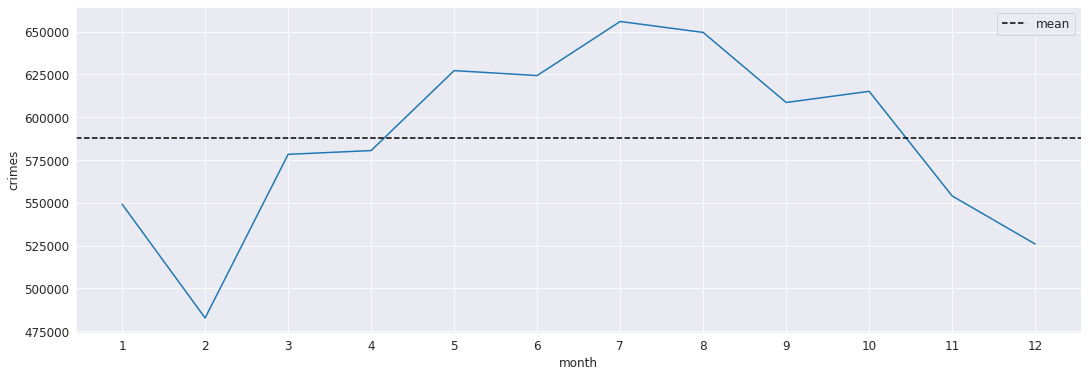

In [8]:
month_crimes = """
               SELECT EXTRACT(MONTH FROM date) AS month, COUNT(*) AS crimes, (SELECT ROUND(COUNT(unique_key) / 12, 0)
                                                                             FROM `bigquery-public-data.chicago_crime.crime`
                                                                             WHERE year < 2020) AS average
               FROM `bigquery-public-data.chicago_crime.crime`
               WHERE year < 2020
               GROUP BY month
               """

month_crimes_data = chicago_crime.query_to_pandas(month_crimes)

plt.figure(figsize=(18, 6))
sns.lineplot(x='month', y='crimes', data=month_crimes_data)
plt.xticks(np.arange(1, 13, 1))
plt.axhline(month_crimes_data['average'][0], linestyle='--', color='k', label='mean')
plt.legend()
plt.show()

#### • *We see that the plot doesn't have much noise, it seems that there could be some relationship.*
#### • *Perhaps analyzing between seasons can give us more information.*

## Crimes per season

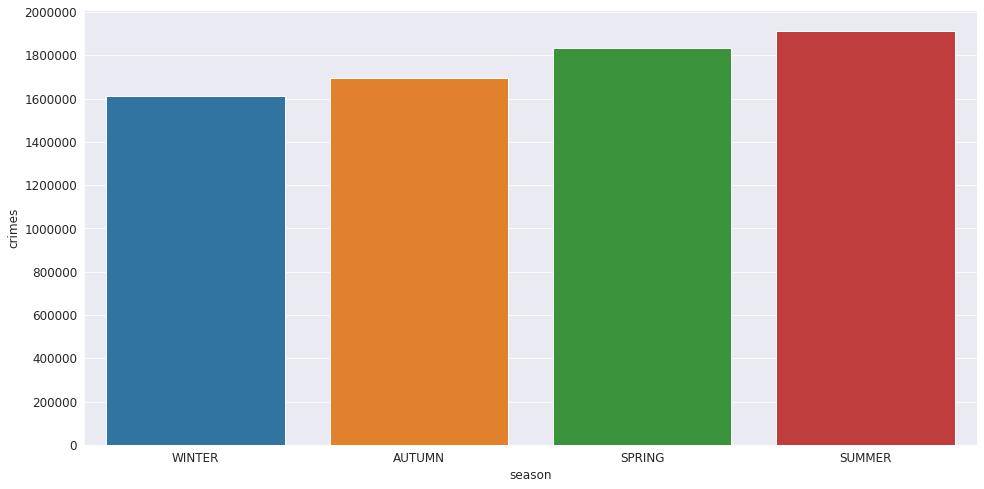

In [9]:
season = """
          SELECT (CASE WHEN EXTRACT(QUARTER FROM date) = 2 THEN 'SPRING'
                       WHEN EXTRACT(QUARTER FROM date) = 3 THEN 'SUMMER'
                       WHEN EXTRACT(QUARTER FROM date) = 4 THEN 'AUTUMN'
                       ELSE 'WINTER' END) AS season, COUNT(*) as crimes
          FROM `bigquery-public-data.chicago_crime.crime`
          WHERE year < 2020
          GROUP BY season
          """
season_data = chicago_crime.query_to_pandas(season)
f, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x='season', y='crimes', data=season_data, ax=ax, order=['WINTER', 'AUTUMN', 'SPRING', 'SUMMER'])
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.yticks(np.arange(0, 2200000, 200000))
plt.show()

#### • *More heat, more crimes, interesting.*
#### • *There could be many reasons, I would say probably the simplest: there is more activity when it is hotter.*

## Crimes per day of the week

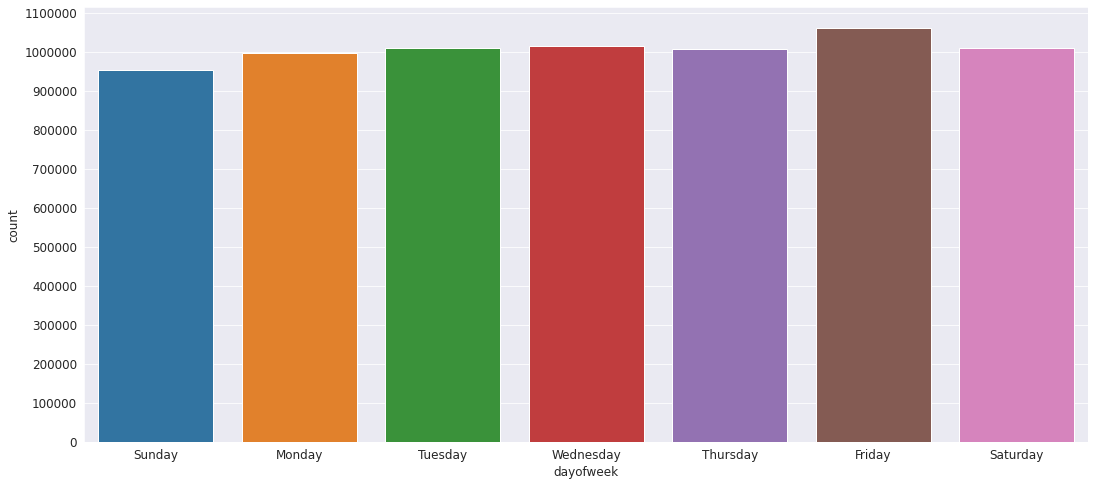

In [10]:
crimes_per_dayofweek = """
                  SELECT EXTRACT(DAYOFWEEK FROM date) AS dayofweek, COUNT(*) AS count
                  FROM `bigquery-public-data.chicago_crime.crime`
                  WHERE year < 2020
                  GROUP BY dayofweek
                  """
f, ax = plt.subplots(figsize=(18, 8))
crimes_per_dayofweek_data = chicago_crime.query_to_pandas(crimes_per_dayofweek)
sns.barplot(x='dayofweek', y='count', data=crimes_per_dayofweek_data)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.yticks(np.arange(0, 1200000, 100000))
plt.show()

#### • *Friday, the day with more crimes.*
#### • *We could assume again that it is because there is more activity on Fridays.*

## Crimes per community areas

In [11]:
community_area_crimes = """
                   SELECT subquery.*, CONCAT('+',ROUND((subquery.crimes / LAG(crimes) OVER (ORDER BY crimes) - 1) * 100, 2), '%') as diff_next
                   FROM (SELECT community_area, COUNT(*) as crimes
                         FROM `bigquery-public-data.chicago_crime.crime`
                         WHERE year < 2020 AND community_area IS NOT NULL
                         GROUP BY community_area) AS subquery
                   ORDER BY crimes DESC
                   """
community_area_data = chicago_crime.query_to_pandas(community_area_crimes)
community_area_data.set_index('community_area').head(10)

,crimes,diff_next
community_area,,
25,407981,+82.61%
8,223415,+6.28%
43,210222,+3.39%
23,203326,+6.36%
28,191176,+0.69%
24,189866,+0.82%
67,188319,+0.57%
29,187249,+2.56%
71,182576,+6.45%


#### • *Community area 25, the one with more crimes, 82.61% more crimes that community area 8 (the second with more crimes).*
#### • *Is it because there is more insecurity? Or maybe it has the largest area? Or is the one with more population density?, Sadly we don't have enough information.*

## Percentage of arrest by location description

In [12]:
location_desc_crimes = """
                       SELECT location_description, COUNT(*) as count, 
                       COUNTIF(arrest = TRUE) AS arrests, 
                       CONCAT(ROUND((COUNTIF(arrest = TRUE) / COUNT(*)) * 100, 2), '%') AS percent_arrests
                       FROM `bigquery-public-data.chicago_crime.crime`
                       WHERE year < 2020 AND location_description <> 'OTHER'
                       GROUP BY location_description
                       HAVING COUNT(*) > 100000
                       ORDER BY percent_arrests DESC
                       """
location_desc_data = chicago_crime.query_to_pandas(location_desc_crimes)

location_desc_data.set_index('location_description')

,count,arrests,percent_arrests
location_description,,,
SIDEWALK,688281,351610,51.09%
RESIDENCE-GARAGE,135212,7752,5.73%
ALLEY,156603,71679,45.77%
VEHICLE NON-COMMERCIAL,113937,35388,31.06%
RESIDENCE PORCH/HALLWAY,123538,37860,30.65%
"SCHOOL, PUBLIC, BUILDING",145770,44201,30.32%
STREET,1834909,524029,28.56%
SMALL RETAIL STORE,127275,34631,27.21%
RESTAURANT,113620,23476,20.66%


#### • *At the top 'sidewalk' with 51.09 percentage of arrests (I'm surprised).*

## Previous years (2016-2019) vs lockdown (2020-2021)

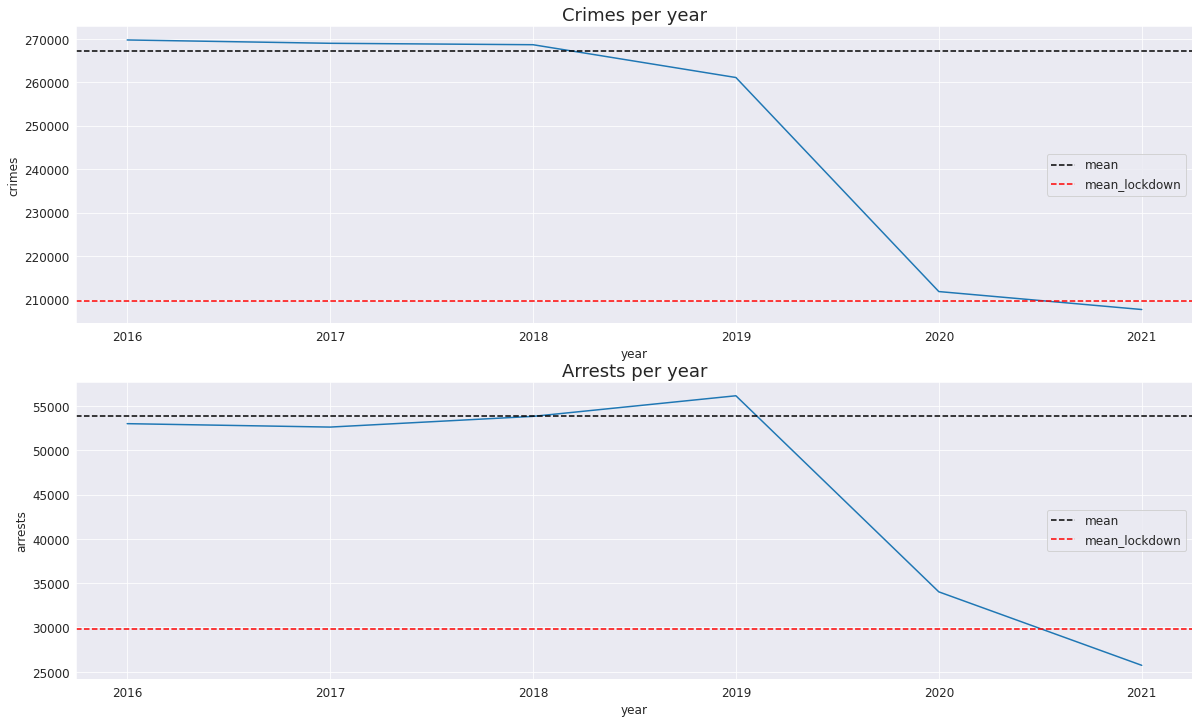

In [13]:
crimes_lockdown = """
                  SELECT year, COUNT(*) AS crimes , (SELECT ROUND(COUNT(unique_key) / COUNT(DISTINCT(year)), 0)
                                                    FROM `bigquery-public-data.chicago_crime.crime`
                                                    WHERE year BETWEEN 2016 AND 2019) AS average,
                                                    (SELECT ROUND(COUNT(unique_key) / COUNT(DISTINCT(year)), 0)
                                                    FROM `bigquery-public-data.chicago_crime.crime`
                                                    WHERE year BETWEEN 2020 AND 2021) AS average_lockdown
                  FROM `bigquery-public-data.chicago_crime.crime`
                  WHERE year BETWEEN 2016 AND 2021
                  GROUP BY year
                  ORDER BY year 
                  """

arrest_lockdown = """
                  SELECT year, COUNT(*) AS arrests , (SELECT ROUND(COUNT(unique_key) / COUNT(DISTINCT(year)), 0)
                                                    FROM `bigquery-public-data.chicago_crime.crime`
                                                    WHERE year BETWEEN 2016 AND 2019 AND arrest = TRUE) AS average,
                                                    (SELECT ROUND(COUNT(unique_key) / COUNT(DISTINCT(year)), 0)
                                                    FROM `bigquery-public-data.chicago_crime.crime`
                                                    WHERE year BETWEEN 2020 AND 2021 AND arrest = TRUE) AS average_lockdown
                  FROM `bigquery-public-data.chicago_crime.crime`
                  WHERE year BETWEEN 2016 AND 2021 AND arrest = TRUE
                  GROUP BY year
                  ORDER BY year 
                  """

crimes_per_year_data = chicago_crime.query_to_pandas(crimes_lockdown)
arrest_per_year_data = chicago_crime.query_to_pandas(arrest_lockdown)

fig, axes = plt.subplots(2, 1, figsize=(20, 12))

plt.sca(axes[0])
sns.lineplot(x='year', y='crimes', data=crimes_per_year_data).set_title('Crimes per year', fontsize=18)
plt.xticks(np.arange(2016, 2022, 1))
plt.axhline(crimes_per_year_data['average'][0], linestyle='--', color='k', label='mean')
plt.axhline(crimes_per_year_data['average_lockdown'][0], linestyle='--', color='r', label='mean_lockdown')
plt.legend()

plt.sca(axes[1])
sns.lineplot(x='year', y='arrests', data=arrest_per_year_data).set_title('Arrests per year', fontsize=18)
plt.xticks(np.arange(2016, 2022, 1))
plt.axhline(arrest_per_year_data['average'][0], linestyle='--', color='k', label='mean')
plt.axhline(arrest_per_year_data['average_lockdown'][0], linestyle='--', color='r', label='mean_lockdown')
plt.legend(loc=7)
plt.show()
#print((crimes_per_year_data['average'][0] - crimes_per_year_data['average_lockdown'][0]) / crimes_per_year_data['average'][0])
#print((arrest_per_year_data['average'][0] - arrest_per_year_data['average_lockdown'][0]) / arrest_per_year_data['average'][0])

#### • *The mean of crimes per year has decreased 21.47% in the lockdown*
#### • *The mean of arrest per year has decreased 44.59% in the lockdown*